In [14]:
"""
Sharpshooter    NBA Tiers: Must include players from each tier.
Scoring Rules

point = +1Pt
3pt Shot = +0.5
Rebound = 1.25 Pts
Assist = +1.5 Pts
Steal = +2 Pts
Block = +2 Pts
Turnover = -0.5 Pts

Double-Double
{Max 1 Per Player:
Points, Rebounds,  = +1.5 Pts
Assists, BLocks,
Steals}

Triple-Double
{Max 1 Per Player:
Points, Rebounds,  = +3 Pts
Assists, BLocks,
Steals}

GP   Games Played 
MIN  Minutes Played 
PTS  Points ***
FGM  Field Goals Made 
FGA  Field Goals Attempted 
FG%  Field Goal Percentage 
3PM  3 Point Field Goals Made 
3PA  3 Point Field Goals Attempted 
3P%  3 Point Field Goals Percentage 
FTM  Free Throws Made 
FTA  Free Throws Attempted 
FT%  Free Throw Percentage 
OREB Offensive Rebounds 
DREB Defensive Rebounds 
REB  Rebounds ***
ST   Assists ***
STL  Steals ***
BLK  Blocks ***
TOV  Turnovers 
EFF  Efficiency
"""
import numpy as np
import pandas as pd
import itertools
from scipy.optimize import minimize, basinhopping, brute
import matplotlib.pyplot as plt 

player_stats = pd.read_csv('player_data.csv', index_col = 'player')
player_stats.head()

,gp,min,pts,fgm,fga,fg%,3pm,3pa,3p%,ftm,fta,ft%,oreb,dreb,reb,ast,stl,blk,tov,eff
player,,,,,,,,,,,,,,,,,,,,
James Harden,25,36.1,30.9,9.2,20.4,45.4,4.1,11.0,37.2,8.3,9.9,83.9,0.6,5.2,5.8,8.3,2.0,0.5,5.6,29.2
Kevin Durant,30,35.7,29.0,10.1,19.8,51.1,1.7,4.8,35.9,7.1,7.6,93.0,0.5,7.2,7.7,6.2,0.9,1.0,3.5,31.1
LeBron James,29,34.8,28.2,10.3,19.7,52.4,2.2,5.9,37.4,5.3,7.7,68.8,0.9,6.9,7.8,7.1,1.3,0.7,3.4,29.9
Anthony Davis,26,37.0,28.1,10.1,20.1,50.2,0.8,2.6,30.9,7.1,8.7,81.9,3.3,9.0,12.4,4.7,1.7,2.8,2.3,35.7
Joel Embiid,29,34.4,27.0,8.8,18.6,47.1,1.2,4.1,29.2,8.2,10.4,79.4,2.4,11.1,13.6,3.6,0.6,1.9,3.3,31.3


In [15]:
player_salary = pd.read_csv('player_salary.csv', index_col = 'player')
player_salary.head()

,Roster Position,Salary
player,,
Anthony Davis,PF/C/F/UTIL,11600
LeBron James,SF/PF/F/UTIL,10900
Nikola Jokic,C/UTIL,9900
John Wall,PG/G/UTIL,9200
Kawhi Leonard,SF/PF/F/UTIL,9000


In [20]:
player_stats.loc['LeBron James']

gp      29.0
min     34.8
pts     28.2
fgm     10.3
fga     19.7
fg%     52.4
3pm      2.2
3pa      5.9
3p%     37.4
ftm      5.3
fta      7.7
ft%     68.8
oreb     0.9
dreb     6.9
reb      7.8
ast      7.1
stl      1.3
blk      0.7
tov      3.4
eff     29.9
Name: LeBron James, dtype: float64

In [9]:
player_stats.loc['Anthony Davis']

gp      26.0
min     37.0
pts     28.1
fgm     10.1
fga     20.1
fg%     50.2
3pm      0.8
3pa      2.6
3p%     30.9
ftm      7.1
fta      8.7
ft%     81.9
oreb     3.3
dreb     9.0
reb     12.4
ast      4.7
stl      1.7
blk      2.8
tov      2.3
eff     35.7
Name: Anthony Davis, dtype: float64

In [ ]:
score_cols = ['pts','3pm','ast','reb','stl','blk','tov']

In [17]:
tier_players = {'tier1' : ['Anthony Davis','LeBron James','Nikola Jokic'],
                
                'tier2' : ['Kawhi Leonard','Jrue Holiday','John Wall','Bradley Beal',
                           'Julius Randle'],
                
                'tier3' : ['Kyle Lowry','Hassan Whiteside','DeAaron Fox', 'Luka Doncic',
                           'DeAndre Jordan','Kyle Kuzma'],
                
                'tier4' : ['Josh Richardson','Jamal Murray','Cauley Stein','Serge Ibaka',
                           'Buddy Hield','Lonzo Ball'],
                
                'tier5' : ['Harrison Barnes','B. Bogdanovic','Dennis Smith Jr.','Markieff Morris',
                           'Bam Adebayo','Fred VanVleet',
                          'J. Hernangomez','Kelly Olynyk'],
                
                'tier6' : ['JaVale McGee','Nemanja Bjelica','Justise Winslow','Danny Green',
                           'Mason Plumlee','Trey Lyles',
                          'Josh Hart','Tim Frazier']
               }

score_options = [1.0, 0.5, 1.25, 1.5, 2.0, 2.0, -0.5, 2]

t1r = np.linspace(0,np.size(tier_players['tier1'])-1, np.size(tier_players['tier1']), dtype = int)
t2r = np.linspace(0,np.size(tier_players['tier2'])-1, np.size(tier_players['tier2']), dtype = int)
t3r = np.linspace(0,np.size(tier_players['tier3'])-1, np.size(tier_players['tier3']), dtype = int)
t4r = np.linspace(0,np.size(tier_players['tier4'])-1, np.size(tier_players['tier4']), dtype = int)
t5r = np.linspace(0,np.size(tier_players['tier5'])-1, np.size(tier_players['tier5']), dtype = int)
t6r = np.linspace(0,np.size(tier_players['tier6'])-1, np.size(tier_players['tier6']), dtype = int)

def scoring(t1, t2, t3, t4, t5, t6, player_stats, tier_players, score_options):
    
    tier_scores = [np.dot(player_stats[tier_players['tier1'][t1]] , score_options),
                   np.dot(player_stats[tier_players['tier2'][t2]] , score_options),
                   np.dot(player_stats[tier_players['tier3'][t3]] , score_options),
                   np.dot(player_stats[tier_players['tier4'][t4]] , score_options),
                   np.dot(player_stats[tier_players['tier5'][t5]] , score_options),
                   np.dot(player_stats[tier_players['tier6'][t6]] , score_options)]

    total_points = np.sum(tier_scores)
    
    return total_points

In [19]:
x0 = [0,2,2,0,0,2]
scoring(0,2,2,0,0,2, player_stats, tier_players, score_options)

KeyError: 'Anthony Davis'

In [509]:
#fun random search
rdm_t1 = np.random.choice(t1r)
rdm_t2 = np.random.choice(t2r)
rdm_t3 = np.random.choice(t3r)
rdm_t4 = np.random.choice(t4r)
rdm_t5 = np.random.choice(t5r)
rdm_t6 = np.random.choice(t6r)

x0 = [rdm_t1,rdm_t2,rdm_t3,rdm_t4,rdm_t5,rdm_t6]
scoring(x0, player_stats, tier_players, score_options)

599.2499999999999

In [461]:
#Let's vectorize the function
scoring_vect = np.vectorize(dev_scoring , excluded = [6,7,8])

#create a meshgrid
Tr1, Tr2, Tr3, Tr4, Tr5, Tr6 = np.meshgrid(t1r, t2r, t3r, t4r, t5r, t6r)

results = scoring_vect(Tr1, Tr2, Tr3, Tr4, Tr5, Tr6, player_stats, tier_players, score_options)

In [517]:
-np.sort(-results, axis = None)

array([625.8  , 625.075, 624.675, ..., 491.725, 489.7  , 489.625])

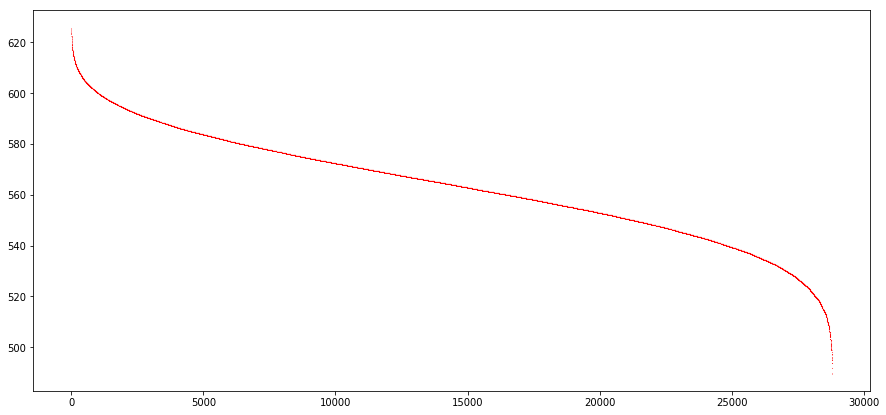

In [462]:
fig, ax = plt.subplots(figsize = (15,7,))
plt.plot(-np.sort(-results, axis = None),  '*r', markersize = 0.1)
plt.show()

In [463]:
np.max(results)

625.8

In [464]:
np.min(results)

489.62499999999994